## Baseball statistics

Read in data and import necessary libraries.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.cross_validation as cv
from sklearn import linear_model
from scipy.stats import norm
import os

baseball_dir = 'baseball_stats/'
player_salaries = pd.read_csv(baseball_dir + 'Salaries.csv', sep=',')
batting = pd.read_csv(baseball_dir + 'Batting.csv', sep=',')

We chose to look at the relationship between home runs and salaries.

In [23]:
grouped_salaries = player_salaries.groupby(["playerID"])["salary"].sum()
total_hr = batting.groupby(["playerID"])[["HR", "G"]].sum()

important_stats = pd.concat((grouped_salaries, total_hr), axis=1)
important_stats = important_stats[(important_stats.salary > 0) & (important_stats.HR > 0) & (important_stats.G > 0)]

A scatterplot to visualize the career home runs and salary for players:

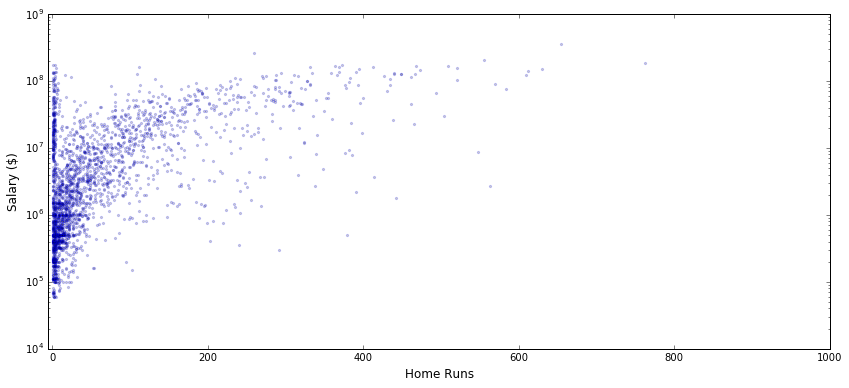

In [29]:
plt.figure(figsize=(14, 6))
plt.scatter(important_stats.HR, important_stats.salary, edgecolor='b', s=5, c='k', alpha=0.2)
plt.yscale('log')
plt.xlabel('Home Runs', fontsize=12); plt.ylabel("Salary ($)", fontsize=12)
plt.xlim(-5, 1000)
plt.show()

Here we create our model for plotting a line for this relationship.

In [31]:
kfolds = cv.KFold(len(important_stats), n_folds=8)

regressor = linear_model.LinearRegression()
Xvalues = np.array(important_stats.HR)[:, np.newaxis]
Yvalues = np.array(important_stats.salary)

slopes, intercepts = [], []

for train_index, test_index in kfolds:
    X_train, X_test = Xvalues[train_index], Xvalues[test_index]
    Y_train, Y_test = Yvalues[train_index], Yvalues[test_index]
    regressor.fit(X_train, Y_train)
    slopes.append(regressor.coef_)
    intercepts.append(regressor.intercept_)
    
slope = np.mean(slopes)
intercept = np.mean(intercepts)

regressor.coef_ = slope
regressor.intercept_ = intercept

print('Our model is:\n\tSalary = %.2f X Home_Runs + %.2f' % (slope, intercept))

Our model is:
	Salary = 179561.00 X Home_Runs + 2701557.20


In [51]:
sig = np.std(slopes)
out_str = "Mean Salary: %.2f" % slope
out_str += "\n\t68-pct confidence int:\t (%.2f, %.2f)" % (slope - sig, slope + sig)
out_str += "\n\t95-pct confidence int:\t (%.2f, %.2f)" % (slope - 2*sig, slope + 2*sig)
out_str += "\n\t99.7-pct confidence int: (%.2f, %.2f)" % (slope - 3*sig, slope + 3*sig)
out_str += "\n\nThe true mean: %.2f" % np.mean(slopes)
print(out_str)

Mean Salary: 179561.00
	68-pct confidence int:	 (176894.43, 182227.58)
	95-pct confidence int:	 (174227.85, 184894.16)
	99.7-pct confidence int: (171561.27, 187560.73)

The true mean: 179561.00


Now we will plot our line over our existing data:

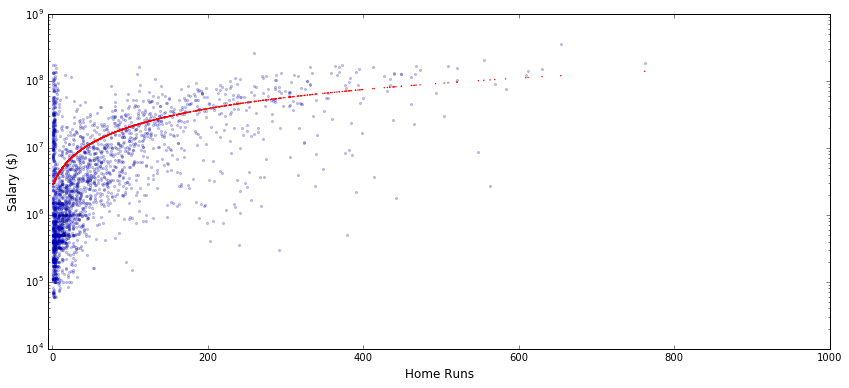

In [32]:
plt.figure(figsize=(14, 6))
plt.scatter(important_stats.HR, important_stats.salary, edgecolor='b', s=5, c='k', alpha=0.2)
plt.scatter(Xvalues, regressor.predict(Xvalues), edgecolor="None", s=2, c='r')
plt.yscale('log')
plt.xlabel('Home Runs', fontsize=12); plt.ylabel("Salary ($)", fontsize=12)
plt.xlim(-5, 1000)
plt.show()

In [33]:
print("Score: {0}".format(regressor.score(Xvalues, Yvalues)))

Score: 0.3761164657676612


In [39]:
grouped_salaries = player_salaries.groupby(["playerID"])["salary"].sum()
batting_data = batting.groupby(["playerID"])[["HR", "G", "AB", "H"]].sum()
multi_stats = pd.concat((grouped_salaries, batting_data), axis=1)
multi_stats = multi_stats[(multi_stats.H > 0) & (multi_stats.salary > 0) & (multi_stats.HR > 0) & (multi_stats.G > 0) & (multi_stats.AB > 0)]

In [40]:
kfolds = cv.KFold(len(multi_stats), n_folds=8)

regressor = linear_model.LinearRegression()
valid_data = ["HR", "G", "AB", "H"]
Xvals = np.array(multi_stats[valid_data])
yvals = np.array(multi_stats.salary)

coeffs, intercepts = [], []

for train_index, test_index in kfolds:
    X_train, X_test = Xvals[train_index], Xvals[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    regressor.fit(X_train, y_train)
    coeffs.append(regressor.coef_)
    intercepts.append(regressor.intercept_)

coeffs = np.array(coeffs).mean(axis=0) #averages each column
intercept = np.array(intercepts).mean(axis=0)

regressor.coef_ = coeffs
regressor.intercept_ = intercept

In [41]:
print("Score: {0}".format(regressor.score(Xvals, yvals)))

Score: 0.4239919277067651


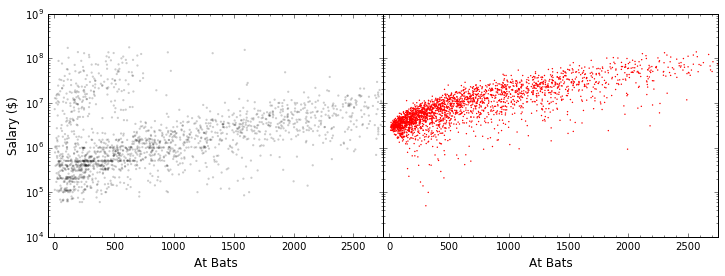

In [50]:
fig = plt.figure(figsize=(12, 4))
fig.subplots_adjust(wspace=0)
ax = plt.subplot(121)
ax.scatter(multi_stats.AB, multi_stats.salary, edgecolor="None",
            s=5, c='k', alpha=0.2)
ax.set_yscale("log")
ax.set_xlabel("At Bats", fontsize=12); ax.set_ylabel("Salary ($)", fontsize=12)
ax.set_xlim(-50, 2750); ax.minorticks_on()

ax = plt.subplot(122)
ax.scatter(Xvals[:, 1], regressor.predict(Xvals), edgecolor="None",
            s=2, c='r')
ax.set_xlabel("At Bats", fontsize=12)
ax.set_ylim(1E4, 1E9)
ax.set_yscale("log"); ax.set_yticklabels([])
ax.set_xlim(-50, 2750); ax.minorticks_on()

plt.show()